## Preprocessing 

In [86]:
! pip install kagglehub

   ---------------------------------------- 0.0/68.3 kB ? eta -:--:--
   ------------------------ --------------- 41.0/68.3 kB ? eta -:--:--
   ------------------------------------ --- 61.4/68.3 kB 825.8 kB/s eta 0:00:01
   ---------------------------------------- 68.3/68.3 kB 617.2 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
# === Cell 0 ===
# Robust dataset locator: finds Alzheimer_Dataset_V2/train even after a session reset.
from pathlib import Path
import os

def get_data_root():

    bases = [
        Path.home() / ".cache" / "kagglehub" / "datasets" / "ashrafulhossenakash" / "alzheimer-disease-dataset",
        Path("/root/.cache/kagglehub/datasets/ashrafulhossenakash/alzheimer-disease-dataset"),
    ]

    for base in bases:
        if base.exists():
            for p in base.glob("versions/*/Alzheimer_Dataset_V2"):
                if (p / "train").exists():
                    return p
            for p in base.glob("versions/*"):
                if (p / "train").exists() and (p / "val").exists() and (p / "test").exists():
                    return p


    env_root = os.environ.get("ALZ_DATA_ROOT")
    if env_root and (Path(env_root) / "train").exists():
        return Path(env_root)


    try:
        import kagglehub
        dl_path = kagglehub.dataset_download("ashrafulhossenakash/alzheimer-disease-dataset")
        dl = Path(dl_path)
        v2 = dl / "Alzheimer_Dataset_V2"
        if (v2 / "train").exists():
            return v2
        for p in dl.rglob("Alzheimer_Dataset_V2"):
            if (p / "train").exists():
                return p
        if (dl / "train").exists() and (dl / "val").exists() and (dl / "test").exists():
            return dl
    except Exception as e:
        pass

    raise FileNotFoundError(
        "Could not locate the dataset. Set ALZ_DATA_ROOT to the folder that contains 'train/ val/ test/'."
    )

DATA_ROOT = get_data_root()
print("DATA_ROOT ->", DATA_ROOT)
print("Has train? ", (DATA_ROOT/'train').exists())


100%|███████████████████████████████████████████████████████████████████████████████| 346M/346M [00:36<00:00, 9.82MB/s]

Extracting files...


DATA_ROOT -> C:\Users\ghaid\.cache\kagglehub\datasets\ashrafulhossenakash\alzheimer-disease-dataset\versions\7\Alzheimer_Dataset_V2
Has train?  True


TRAIN counts (before):
  MildDemented: 6272
  ModerateDemented: 4524
  NonDemented: 6720
  VeryMildDemented: 6272
  Total: 23788


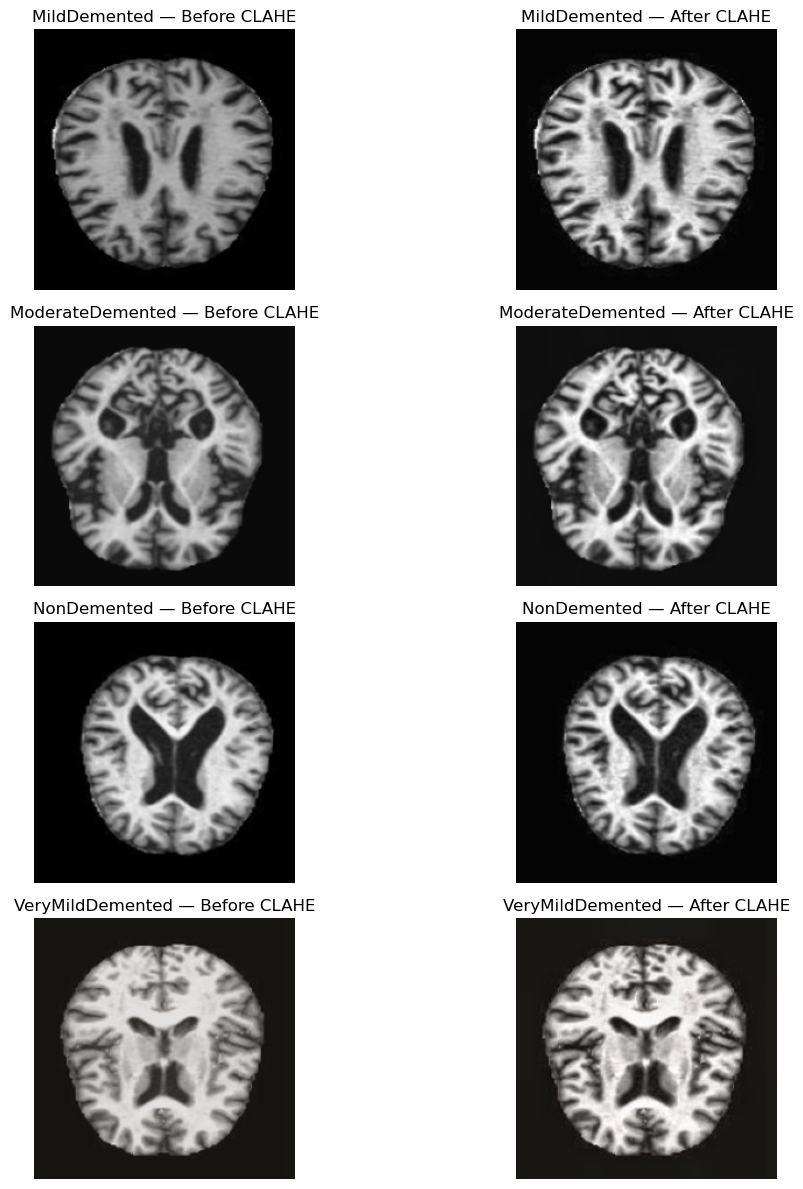

In [3]:
# === Cell 1 ===
# Setup + count + show before/after enhancement

import os, random, shutil
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


DATA_ROOT = DATA_ROOT = DATA_ROOT


TRAIN_DIR = DATA_ROOT / "train"
IMG_EXTS = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")

def list_images(folder: Path):
    return [f for f in os.listdir(folder) if f.lower().endswith(IMG_EXTS)]

def count_split(split_dir: Path):
    counts = {}
    for cls in sorted(os.listdir(split_dir)):
        cpath = split_dir / cls
        if cpath.is_dir():
            counts[cls] = len(list_images(cpath))
    return counts

import cv2

class ApplyCLAHE:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8,8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img: Image.Image) -> Image.Image:
        arr = np.array(img)
        if arr.ndim == 2:
            clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
            out = clahe.apply(arr)
            return Image.fromarray(out)
        elif arr.ndim == 3:
            lab = cv2.cvtColor(arr, cv2.COLOR_RGB2LAB)
            L, A, B = cv2.split(lab)
            clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
            L2 = clahe.apply(L)
            lab2 = cv2.merge((L2, A, B))
            rgb2 = cv2.cvtColor(lab2, cv2.COLOR_LAB2RGB)
            return Image.fromarray(rgb2)
        return img

enhancer = ApplyCLAHE()

counts_before = count_split(TRAIN_DIR)
print("TRAIN counts (before):")
for k, v in counts_before.items():
    print(f"  {k}: {v}")
print("  Total:", sum(counts_before.values()))

classes = sorted(list(counts_before.keys()))
n = len(classes)
plt.figure(figsize=(12, 3*n))
for i, cls in enumerate(classes):
    cpath = TRAIN_DIR / cls
    files = list_images(cpath)
    if not files:
        continue
    img_path = cpath / random.choice(files)
    original = Image.open(img_path).convert("RGB")
    # Enhancement -> Resize (224,224)
    before = original.resize((224,224))
    after  = enhancer(before)

    plt.subplot(n, 2, 2*i+1)
    plt.imshow(before)
    plt.title(f"{cls} — Before CLAHE")
    plt.axis("off")

    plt.subplot(n, 2, 2*i+2)
    plt.imshow(after)
    plt.title(f"{cls} — After CLAHE")
    plt.axis("off")

plt.tight_layout()
plt.show()


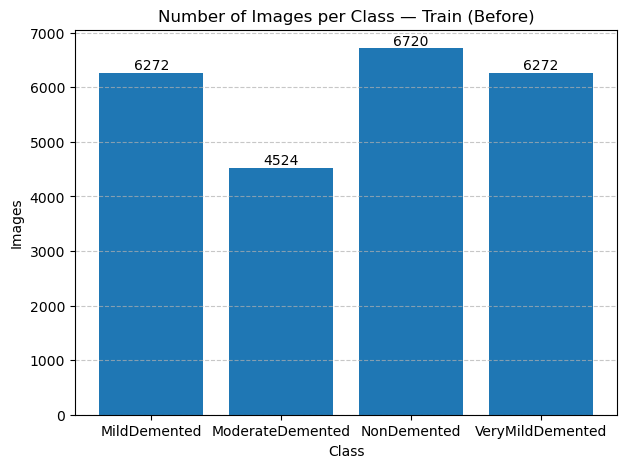

In [4]:
# === Cell 2 ===
# Bar chart of train counts BEFORE augmentation

import matplotlib.pyplot as plt

classes = list(counts_before.keys())
values  = [counts_before[c] for c in classes]

plt.figure(figsize=(7,5))
plt.bar(classes, values)
plt.title("Number of Images per Class — Train (Before)")
plt.xlabel("Class")
plt.ylabel("Images")
plt.grid(axis="y", linestyle="--", alpha=0.7)

for i, v in enumerate(values):
    plt.text(i, v, str(v), ha="center", va="bottom")

plt.show()


In [7]:
# === Cell 3 ===
# Build a balanced train set using enhanced images (CLAHE + Resize) for augmentation


from torchvision import transforms
import random

BALANCED_ROOT = Path("./train_balanced")  # الناتج
BALANCED_ROOT.mkdir(parents=True, exist_ok=True)

TARGET_CLASS = "ModerateDemented"
resize_to = (224, 224)

augment = transforms.Compose([
    transforms.RandomApply([transforms.ElasticTransform(alpha=50.0)], p=0.5),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.3, contrast=0.3)], p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
])

target_count = max(counts_before.values())
print("Target count for balancing:", target_count)

def symlink_or_copy(src: Path, dst: Path):
    try:
        if dst.exists():
            return
        os.symlink(src, dst)
    except OSError:
        if not dst.exists():
            shutil.copy2(src, dst)

for cls in counts_before.keys():
    src_cls = TRAIN_DIR / cls
    dst_cls = BALANCED_ROOT / cls
    dst_cls.mkdir(exist_ok=True, parents=True)

    files = [f for f in list_images(src_cls)]
    for f in files:
        src = src_cls / f
        dst = dst_cls / f
        symlink_or_copy(src, dst)

src_cls = TRAIN_DIR / TARGET_CLASS
dst_cls = BALANCED_ROOT / TARGET_CLASS
dst_cls.mkdir(exist_ok=True, parents=True)

current_files = [f for f in os.listdir(dst_cls) if f.lower().endswith(IMG_EXTS)]
current_count = len(current_files)

if current_count > target_count:
    keep = set(random.sample(current_files, target_count))
    for f in current_files:
        if f not in keep:
            try:
                os.remove(dst_cls / f)
            except FileNotFoundError:
                pass
    print(f"[Trimmed] {TARGET_CLASS}: kept {target_count}, removed {current_count - target_count}")
    current_count = target_count

elif current_count < target_count:
    base_files = [f for f in list_images(src_cls)]
    i = 0
    while current_count < target_count and base_files:
        f = random.choice(base_files)
        img = Image.open(src_cls / f).convert("RGB")
        # Enhancement -> Resize -> Augmentation
        img_enh = enhancer(img.resize(resize_to))
        img_aug = augment(img_enh)
        out_name = f"aug_{i:06d}.jpg"
        out_path = dst_cls / out_name
        while out_path.exists():
            i += 1
            out_name = f"aug_{i:06d}.jpg"
            out_path = dst_cls / out_name
        img_aug.save(out_path, format="JPEG", quality=95)
        i += 1
        current_count += 1

    print(f"[Augmented] {TARGET_CLASS}: now {current_count} images (target {target_count})")
else:
    print(f"[Balanced] {TARGET_CLASS} already at target: {target_count}")


Target count for balancing: 6720
[Balanced] ModerateDemented already at target: 6720


TRAIN counts (after):
  MildDemented: 6272
  ModerateDemented: 6720
  NonDemented: 6720
  VeryMildDemented: 6272
  Total: 25984


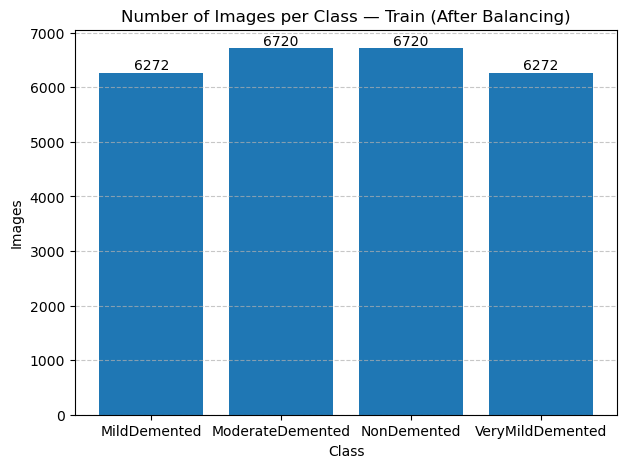

In [9]:
# === Cell 4 ===
# Count AFTER balancing + final bar chart

def count_split(path: Path):
    counts = {}
    for cls in sorted(os.listdir(path)):
        cpath = path / cls
        if cpath.is_dir():
            counts[cls] = len([f for f in os.listdir(cpath) if f.lower().endswith((".png",".jpg",".jpeg",".bmp",".tif",".tiff"))])
    return counts

counts_after = count_split(BALANCED_ROOT)

print("TRAIN counts (after):")
for k, v in counts_after.items():
    print(f"  {k}: {v}")
print("  Total:", sum(counts_after.values()))


import matplotlib.pyplot as plt

classes = list(counts_after.keys())
values  = [counts_after[c] for c in classes]

plt.figure(figsize=(7,5))
plt.bar(classes, values)
plt.title("Number of Images per Class — Train (After Balancing)")
plt.xlabel("Class")
plt.ylabel("Images")
plt.grid(axis="y", linestyle="--", alpha=0.7)

for i, v in enumerate(values):
    plt.text(i, v, str(v), ha="center", va="bottom")

plt.show()


In [11]:
# === Cell 5 ===

from pathlib import Path
import shutil
from PIL import Image
from tqdm import tqdm

READY_ROOT = Path("./alzheimers_dataset")
(READY_ROOT/"train_final").mkdir(parents=True, exist_ok=True)
(READY_ROOT/"val_final").mkdir(parents=True, exist_ok=True)
(READY_ROOT/"test_final").mkdir(parents=True, exist_ok=True)

if (READY_ROOT/"train_final").exists():
    shutil.rmtree(READY_ROOT/"train_final")
shutil.copytree(BALANCED_ROOT, READY_ROOT/"train_final")

def prepare_split(src_dir, dst_dir):
    if dst_dir.exists():
        shutil.rmtree(dst_dir)
    dst_dir.mkdir(parents=True, exist_ok=True)
    for cls in os.listdir(src_dir):
        src_cls = Path(src_dir)/cls
        dst_cls = dst_dir/cls
        dst_cls.mkdir(parents=True, exist_ok=True)
        for f in tqdm(list_images(src_cls), desc=f"Processing {cls}"):
            img = Image.open(src_cls/f).convert("RGB")
            img = enhancer(img.resize((224,224)))
            img.save(dst_cls/f, format="JPEG", quality=95)

prepare_split(DATA_ROOT/"val", READY_ROOT/"val_final")
prepare_split(DATA_ROOT/"test", READY_ROOT/"test_final")

print("alzheimers_dataset")
print(" - train_final (Balanced, Augmented)")
print(" - val_final   (Enhanced only)")
print(" - test_final  (Enhanced only)")



Processing VeryMildDemented: 100%|█████████████████████████████████████████████████| 1344/1344 [00:38<00:00, 34.57it/s]


alzheimers_dataset
 - train_final (Balanced, Augmented)
 - val_final   (Enhanced only)
 - test_final  (Enhanced only)


In [ ]:
"""
Lyane's comment

What has been done?

Original dataset: Downloaded the Alzheimer Disease Dataset V2.

Enhancement: Applied CLAHE (Contrast Limited Adaptive Histogram Equalization) to improve brightness/contrast.

Resize: All images were resized to a fixed size of 224×224.

Augmentation: Applied augmentation (Elastic, ColorJitter, Horizontal Flip, Rotation) only to the ModerateDemented class to balance it with the other classes.

Balancing: All classes in the train set now have the same number of images (balanced).

Final splits created:

train_final/ → Enhanced + Augmented (balanced)

val_final/ → Enhanced only (no augmentation)

test_final/ → Enhanced only (no augmentation)

 How to use the dataset?

***********Use only this folder: alzheimers_dataset/********

It contains three subfolders:

train_final

val_final

test_final

"""